### Todo
- short time interval graph generation - done
- clean and improve data - done

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import geopandas as gpd
from shapely.geometry import Point
import pyproj
#pyproj.datadir.set_data_dir('/usr/local/share/proj')
from pyproj import CRS, Transformer
import folium

In [2]:
# this script is create by A. Biricz, ?.12.2020.
# Arguments:
# --source_folder
# --target_folder

# Add command line arguments

import numpy as np
import pandas as pd
from itertools import product
import os
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm

# Locate files
source = '/media/Data_storage/Mobilcell/Data/'
target = '/media/Data_storage/Mobilcell/DayEventData/'

files_events = np.array( sorted([ i for i in os.listdir(source) if 'EVENTS' in i]) )
files_poligons = np.array( sorted([ i for i in os.listdir(source) if 'POLIGONS' in i]) )
files_events_cleaned = np.array( sorted([ i for i in os.listdir(source) if 'Events' in i]) )

In [3]:
poligons_path = files_poligons[100]
events_path = files_events[100]
# load data
print("loading input data")
poligons_df = pd.read_csv( source+poligons_path, delimiter=';' )
events_df = pd.read_csv( source+events_path, delimiter=';' )

# drop poligons outside of the country
poligons_df = poligons_df[ np.logical_and( poligons_df.eovx.values < 366660, 
                                           poligons_df.eovx.values > 48210 ) ]
poligons_df = poligons_df[ np.logical_and( poligons_df.eovy.values < 934219, 
                                           poligons_df.eovy.values > 426341 ) ]

# create coordinate system for the rasters (much easier and faster to generate than search and match)
start_x = poligons_df.eovx.values.min()
start_y = poligons_df.eovy.values.min()
end_x = poligons_df.eovx.values.max()
end_y = poligons_df.eovy.values.max()
num_x = int( ( end_x - start_x ) / 127 )
num_y = int( ( end_y - start_y ) / 127 )
raster_x = np.arange(start_x, end_x+127, 127, dtype=np.int32)
raster_y = np.arange(start_y, end_y+127, 127, dtype=np.int32)

# get coordinate vector

raster_coords = np.array( list(product( raster_x, raster_y )) )
raster_coords[:3], raster_coords.shape

# calculate raster encodings
poligons_df['eovx_num'] = ( (poligons_df.eovx - start_x) / 127 ).astype(int)
poligons_df['eovy_num'] = ( (poligons_df.eovy - start_y) / 127 ).astype(int)
poligons_df['eov_idx'] = poligons_df.eovx_num * (num_y+1) + poligons_df.eovy_num

# calculate tower encodings
tower_id = np.unique( poligons_df.network_identifier.values )
uniq, counts = np.unique(poligons_df.eov_idx, return_counts=True)
tower_to_int = dict(zip( tower_id, np.arange(tower_id.shape[0]) ))

# add encodings to the dataframes
poligons_df["tower_idx"] = [ tower_to_int[i] for i in poligons_df.network_identifier.values ]
events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]

# sort the smaller dataframe for much quicker searching
poligons_df.sort_values( by='tower_idx', inplace=True )

# calculate event (equipment id) encodings
event_id = np.unique( events_df.equipment_identifier.values )
event_to_int = dict(zip( event_id, np.arange(event_id.shape[0]) ))

# add event encodings to the dataframes
events_df["event_idx"] = [ event_to_int[i] for i in events_df.equipment_identifier.values ]

# partitioning the event dataframe to track individual events
eq_diff_idx = np.where( np.diff(events_df.event_idx.values) )[0]+1
# insert first element (zero) ## otherwise left out!
eq_diff_idx = np.insert(eq_diff_idx, 0, 0, axis=0)
# insert last element (size of array) ## otherwise left out!
eq_diff_idx = np.append( eq_diff_idx, events_df.event_idx.values.shape[0] )


# calculate trajectories of events (to which tower it connects to and when)
eq_trajectories_towers = []
eq_trajectories_time = []
print("calculate trajectories of events..")
for i in tqdm( range( eq_diff_idx.shape[0]-1 ) ):
    start_ = eq_diff_idx[i]
    end_ = eq_diff_idx[i+1]
    eq_trajectories_towers.append( events_df.tower_idx.values[ start_:end_ ] )
    eq_trajectories_time.append( events_df.event_datetime.values[ start_:end_ ] )

# these arrays holds the information about the events
eq_trajectories_towers = np.array( eq_trajectories_towers ) # array of variable length arrays!
eq_trajectories_time = np.array( eq_trajectories_time ) # array of variable length arrays!

# check for unique values and drop events that stand still for the whole day
eq_trajectories_towers_uq = np.array([ np.shape(np.unique(i))[0] for i in eq_trajectories_towers ])
eq_trajectories_time = eq_trajectories_time[ eq_trajectories_towers_uq > 1 ]
eq_trajectories_towers = eq_trajectories_towers[ eq_trajectories_towers_uq > 1 ]

# partitioning the poligon dataframe to locate individual towers
tower_diff_idx = np.where( np.diff(poligons_df.tower_idx.values) )[0]+1
# insert first element (zero) ## otherwise left out!
tower_diff_idx = np.insert(tower_diff_idx, 0, 0, axis=0)
# insert last element (size of array) ## otherwise left out!
tower_diff_idx = np.append( tower_diff_idx, poligons_df.tower_idx.values.shape[0] )

# collect all rasters for the towers
tower_rasters = []
print("collect all rasters for the towers..")
for i in tqdm( range( tower_diff_idx.shape[0]-1 ) ):
    start_ = tower_diff_idx[i]
    end_ = tower_diff_idx[i+1]
    tower_rasters.append( poligons_df.eov_idx.values[ start_:end_ ] )
tower_rasters = np.array(tower_rasters)

# calculate coordinates of the towers (and its error with std for now)
tower_coords_all = []
tower_std_all = []
print("calculate coordinates of the towers..")
for i in tqdm( range( tower_rasters.shape[0] ) ):
    tower_coords_all.append( np.mean( raster_coords[ tower_rasters[i] ], 0 ) )
    tower_std_all.append( np.std( raster_coords[ tower_rasters[i] ], 0 ) )  
tower_coords_all = np.array( tower_coords_all )
tower_std_all = np.array( tower_std_all )

# load datetime variable to code time as minutes
dates_clock = np.loadtxt( "event_datetime.csv").astype(int) # time on clock
dates_time = np.arange( 1440 ) # time in sec
time_to_sec = dict( zip(dates_clock, dates_time) )

loading input data


  0%|          | 9527/4259594 [00:00<00:44, 95266.23it/s]

calculate trajectories of events..


 32%|███▏      | 13855/43147 [00:00<00:00, 138546.83it/s]

collect all rasters for the towers..


  2%|▏         | 927/43147 [00:00<00:04, 9254.98it/s]

calculate coordinates of the towers..


100%|██████████| 43147/43147 [00:03<00:00, 11386.92it/s]


### Investigate how event trajectories can be improved

In [4]:
## PART 1:

eq_info_all = np.zeros( ( np.sum([ len(i) for i in eq_trajectories_towers ]), 9 ), 
                        dtype=np.int32 )
counter = 0
eps = 1e-6 # add small time to avoid division by zero
for curr in tqdm( range( eq_trajectories_towers.shape[0] ) ):
    
    # get indices
    eq_path = np.vstack( (eq_trajectories_towers[curr][:-1], eq_trajectories_towers[curr][1:]) ).T
    
    # filter if source and destination is the same
    filt = (eq_path[:,0] != eq_path[:,1])
    eq_path = eq_path[filt]
    
    # get time in minutes format
    eq_time_ = np.array( list( map(time_to_sec.get, eq_trajectories_time[curr]) ) )
    eq_time_min = eq_time_[1:] - eq_time_[:-1]
    eq_time_min = eq_time_min[filt] / 60 # this becomes hour for calc speed!
    eq_time_ = eq_time_[:-1][filt]
    
    # calculate speed and filter with it
    eq_dist_km = np.sqrt( np.sum( (tower_coords_all[ eq_path[:,1] ] - \
                      tower_coords_all[ eq_path[:,0] ])**2, 1 ) ) / 1000
    eq_speed_kmh = (eq_dist_km/eq_time_min+eps).astype(int)
    filt = np.logical_and( eq_speed_kmh > 3, eq_speed_kmh < 180 )
    
    # saving calculated trajectory
    #eq_info = pd.DataFrame( 
    eq_info = np.concatenate( (
                        curr*np.ones( filt.sum(), dtype=np.int32).reshape(-1,1),
                        eq_time_[filt].reshape(-1,1), 
                        tower_coords_all[ eq_path[:,0] ][filt], 
                        tower_coords_all[ eq_path[:,1] ][filt], 
                        eq_time_min[filt].reshape(-1,1)*60,
                        eq_dist_km[filt].reshape(-1,1)*1000, 
                        eq_speed_kmh[filt].reshape(-1,1)/3.6 ), axis=1).astype(int) #,
#columns=['id',start_time_min','src_x','src_y','dst_x', 'dst_y','trip_time_min', 'dist_m', 'speed_ms'])
    
    for l in range(eq_info.shape[0]):
        eq_info_all[counter] = eq_info[l]
        counter += 1

# drop not needed elements from the end of the array
eq_info_all = eq_info_all[:counter]

## PART 2:

# events that last longer than 30 minutes should be further processed
filt_long_trips = eq_info_all[:, 6 ] > 30 # 6th index means time
eq_info_all_long = eq_info_all[ filt_long_trips ]

# first remove these longer events from the list
eq_info_all = eq_info_all[ ~filt_long_trips ]
"""

# events that last longer than 60 minutes will not be interpolated!
filt_long_trips = eq_info_all_long[:, 6 ] < 60 # 6th index means time
eq_info_all_long = eq_info_all_long[ filt_long_trips ]


# linear interpolation of the longer events to match the time scale of 15 minutes
to_add_all = np.zeros( ( np.sum([ len(i) for i in eq_trajectories_towers ]), 9 ), 
                         dtype=np.int32 )

counter2 = 0
for q in tqdm( range( eq_info_all_long.shape[0] ) ):
    eq_current = eq_info_all_long[q] # select a trip

    # request info of the current movement
    eq_id = eq_current[0]
    start_time = eq_current[1]
    trip_time = eq_current[6]
    end_time = start_time + trip_time
    src_coords = eq_current[2:4]
    dst_coords = eq_current[4:6]
    dist = eq_current[7]
    speed = eq_current[8]
    num_to_interp = np.int( np.ceil( eq_current[6] / 15 ) ) # CHANGED TO CEIL!

    # do linear interpolation (coordinates and time between need to be calc.)
    time_samples = np.linspace( start_time, end_time, num_to_interp+1 ).astype(int)
    coords_samples = np.linspace( src_coords, dst_coords, num_to_interp+1 ).astype(int)

    # index array for consecutive events
    idx_samples = np.vstack( (np.arange(coords_samples.shape[0])[1:], 
                              np.arange(coords_samples.shape[0])[:-1]) ).T
    
    # just add speed from previously calculated trip
    speed_samples = np.ones(num_to_interp, dtype=np.int32)*speed # speed remains the same!

    # divide original distance into parts
    dist_samples = (np.ones(num_to_interp)*dist/num_to_interp).astype(int)
 
    # putting all that together and collect data
    to_add = ( np.concatenate( (  
                eq_id*np.ones(dist_samples.shape[0], dtype=np.int).reshape(-1,1),
                time_samples[:-1].reshape(-1,1), 
                coords_samples[:-1], coords_samples[1:], 
                np.diff(time_samples).reshape(-1,1), 
                dist_samples.reshape(-1,1), 
                speed_samples.reshape(-1,1)), axis=1) )

    for l in range(to_add.shape[0]):
        to_add_all[ counter2 ] = to_add[l]
        counter2 += 1
     
        
# drop not needed elements from the end of the array
to_add_all = to_add_all[:counter2]

eq_info_final = np.concatenate( (eq_info_all, to_add_all), axis=0 )
"""

  0%|          | 0/3383565 [00:00<?, ?it/s]/home/abiricz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/abiricz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 3383565/3383565 [05:46<00:00, 9755.66it/s] 


'\n\n# events that last longer than 60 minutes will not be interpolated!\nfilt_long_trips = eq_info_all_long[:, 6 ] < 60 # 6th index means time\neq_info_all_long = eq_info_all_long[ filt_long_trips ]\n\n\n# linear interpolation of the longer events to match the time scale of 15 minutes\nto_add_all = np.zeros( ( np.sum([ len(i) for i in eq_trajectories_towers ]), 9 ), \n                         dtype=np.int32 )\n\ncounter2 = 0\nfor q in tqdm( range( eq_info_all_long.shape[0] ) ):\n    eq_current = eq_info_all_long[q] # select a trip\n\n    # request info of the current movement\n    eq_id = eq_current[0]\n    start_time = eq_current[1]\n    trip_time = eq_current[6]\n    end_time = start_time + trip_time\n    src_coords = eq_current[2:4]\n    dst_coords = eq_current[4:6]\n    dist = eq_current[7]\n    speed = eq_current[8]\n    num_to_interp = np.int( np.ceil( eq_current[6] / 15 ) ) # CHANGED TO CEIL!\n\n    # do linear interpolation (coordinates and time between need to be calc.)\n    

In [6]:
savename = target + 'output_daily-events-data_' + events_path.split('.csv')[0][-8:]+'.csv.gz'
savename

'/media/Data_storage/Mobilcell/DayEventData/output_daily-events-data_20190311.csv.gz'

In [7]:
savename = target + 'output_daily-events-data_' + events_path.split('.csv')[0][-8:]+'.csv.gz'
pd.DataFrame( eq_info_final,
    columns=['id','start_time_min','src_x','src_y',
             'dst_x', 'dst_y','trip_time_min', 'dist_m', 
             'speed_ms']).to_csv( savename, index=False, compression='gzip' )
    

#### Gain in events number after interpolation: 21.426.372 --> 39.234.054

((21426373, 9), (6516431, 9), 21426373)

In [5]:
eq_info_all.shape, eq_info_all_long.shape, 14909942+6516431

((18492781, 9), (2933592, 9), 21426373)

In [7]:
eq_info_final = eq_info_all

In [21]:
tower_coords_all[:10]

array([[250854.76219358, 557284.1301491 ],
       [243336.62758621, 558383.79891107],
       [247240.38334196, 549715.15985515],
       [248636.48518519, 551081.78171296],
       [273519.00350877, 796044.90701754],
       [270283.4       , 645289.        ],
       [235169.71428571, 657063.71428571],
       [234419.41935484, 656579.70967742],
       [235079.        , 656755.28571429],
       [232756.71428571, 656229.14285714]])

In [19]:
eq_info_final[:100]

array([[     0,    430, 231044, 643889, 231339, 646860,      8,   2985,
             6],
       [     0,    438, 231339, 646860, 234332, 647592,      3,   3081,
            16],
       [     2,    661, 234474, 660827, 234636, 661131,      2,    344,
             2],
       [     2,    663, 234636, 661131, 233269, 660902,      3,   1386,
             7],
       [     2,    666, 233269, 660902, 232797, 660246,      2,    807,
             6],
       [     2,    668, 232797, 660246, 232427, 659708,      1,    652,
            10],
       [     2,    669, 232689, 660344, 232427, 659708,      1,    687,
            11],
       [     2,    670, 232427, 659708, 231404, 657831,     21,   2138,
             1],
       [     2,    691, 231404, 657831, 231004, 659165,      2,   1392,
            11],
       [     2,    693, 231004, 659165, 229616, 659058,      5,   1392,
             4],
       [     2,    698, 229616, 659058, 230230, 658651,      4,    736,
             3],
       [     2,    70

### Visualization on map

#### Filter for 15 minutes range

In [8]:
eq_to_map = eq_info_final[ np.in1d( eq_info_final[:,1], np.arange(600, 630) ) ]
eq_to_map.shape, eq_to_map[:3]

((673223, 9),
 array([[     7,    603, 223629, 659898, 225589, 661267,      3,   2391,
             13],
        [     7,    622, 225589, 661267, 223629, 659898,      8,   2391,
              4],
        [    26,    625, 242483, 646038, 243007, 646164,      5,    539,
              1]], dtype=int32))

#### Filter out motions that takes longer than 30 minutes!

(670958, 9)

In [9]:
eq_to_map = eq_to_map[ eq_to_map[:,6] < 31 ]
eq_to_map.shape

(673223, 9)

In [10]:
eq_path_map = np.array([ np.array( (eq_to_map[i,2:4], eq_to_map[i,4:6]) ) for i in range(eq_to_map.shape[0]) ])
eq_path_map[:3], eq_path_map.shape

(array([[[223629, 659898],
         [225589, 661267]],
 
        [[225589, 661267],
         [223629, 659898]],
 
        [[242483, 646038],
         [243007, 646164]]], dtype=int32), (673223, 2, 2))

In [11]:
eq_mapping = np.zeros(eq_path_map.shape, dtype=np.float32)
eq_mapping.shape

(673223, 2, 2)

In [12]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

In [13]:
 transformer.transform( eq_path_map[0,:,1], eq_path_map[0,:,0] )

(array([47.35660256, 47.37421102]), array([19.17847152, 19.19664257]))

In [14]:
eq_path_map[30,1,:]

array([252975, 637006], dtype=int32)

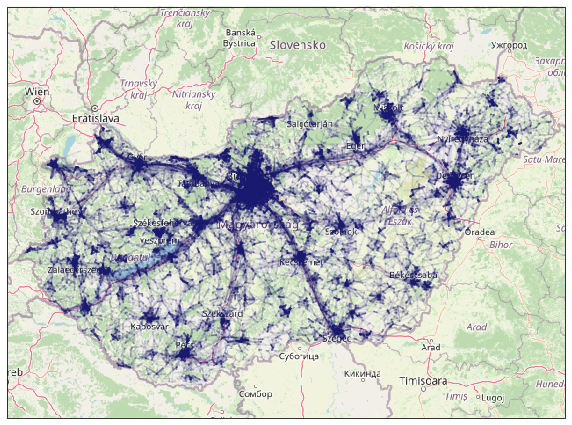

In [17]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

eq_mapping[:,0,:], eq_mapping[:,1,:] = transformer.transform( xx=eq_path_map[:,:,1],
                                                              yy=eq_path_map[:,:,0] )

xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        x=eq_mapping[:,1,:], 
                                        y=eq_mapping[:,0,:])
xynps = np.swapaxes(xynps[:,:,:-1], 1, 2)

for i in range( xynps.shape[0] )[::10]:
    plt.plot( xynps[i,0], xynps[i,1], alpha=0.1, color='midnightblue' )
plt.savefig('motion_snapshot_30_minutes.png', dpi=100)

(43, 9)
(0, 9)


IndexError: too many indices for array

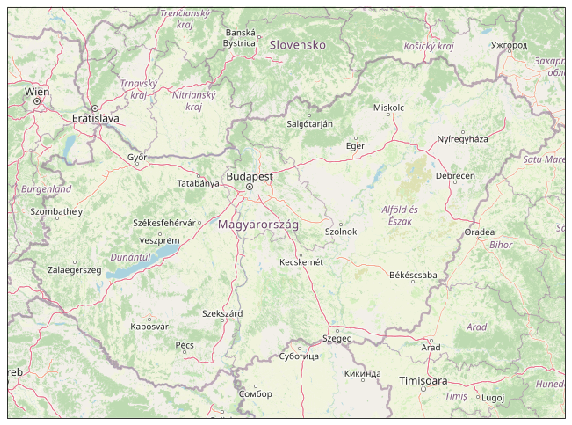

In [20]:
eq_to_map = eq_info_all[ np.in1d( eq_info_all[:,0], np.arange(120, 135) ) ]
print(eq_to_map.shape)
eq_to_map = eq_to_map[ eq_to_map[:,3] < 15 ]
print(eq_to_map.shape)
eq_path_map = np.array([ np.array( (tower_coords_all[i,0], tower_coords_all[i,1]) ) for i in eq_to_map[:,1:3] ])

eq_mapping = np.zeros(eq_path_map.shape, dtype=np.float32)

crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

eq_mapping[:,0,:], eq_mapping[:,1,:] = transformer.transform( xx=eq_path_map[:,1,:],
                                                              yy=eq_path_map[:,0,:] )

xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        x=eq_mapping[:,1,:], 
                                        y=eq_mapping[:,0,:])
xynps = np.swapaxes(xynps[:,:,:-1], 1, 2)

for i in range( xynps.shape[0] ):
    plt.plot( xynps[i,0], xynps[i,1], alpha=0.3, color='midnightblue' )
plt.savefig('motion_snapshot_15_minutes_night.png', dpi=100)

#### To-do:
- mark time bins the given equipment gives contribution into
- 